In [1]:
import numpy as np 
import torch 
import json 
import matplotlib.pyplot as plt 
from omegaconf import OmegaConf
from parchgrad.plot import quantile_plot, alpha_plot
from parchgrad.models.pretrained_models import get_pretrained_model
from parchgrad import get_hook_wrapper
from parchgrad.datasets import get_default_transform
from parchgrad.datasets import IMAGENET_MEAN, IMAGENET_STD, get_datasets
from parchgrad.attribution_methods import get_input_attrib
import torchvision.transforms as T 
labels = json.load(open("../imagenet_label.json", 'rb')) 

In [2]:
# --- dataset 
encoder = "resnet18"
device="cuda:0"
base_dir = f"../outputs/{encoder}"
model = get_pretrained_model(encoder)
model.to(device)
model.eval()

method = 'cls'
wrapper = get_hook_wrapper(encoder, model, method)  # just use cls to gather forward hiddens 
wrapper.prepare_parchgrad(base_directory=base_dir, device=device)

We set all module's inplace=False


In [3]:
data_path='/data/ImageNet1k/'
transform = get_default_transform(wrapper.resize, wrapper.crop, IMAGENET_MEAN, IMAGENET_STD)
_, valid_dataset = get_datasets('imagenet1k', data_path, transform)
transform_2 = T.Compose([
                T.Resize(wrapper.resize, interpolation=T.InterpolationMode.BILINEAR),
                T.CenterCrop(wrapper.crop),
                T.ToTensor(),
                ])

_, valid_dataset_2 = get_datasets('imagenet1k', data_path, transform_2)

[INFO] hook layer3 and layer4 convolutions


3it [00:00, 35.78it/s]


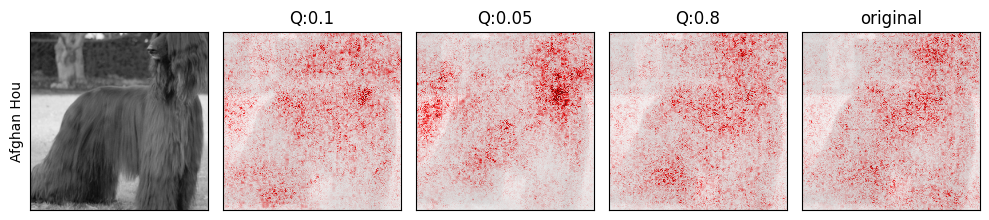

In [13]:
layer_ratio=None # 0.5
selected_convolutions = wrapper.get_default_hook_convolutions(layer_ratio)
wrapper.set_hook_modules(selected_convolutions)

flags = OmegaConf.create({
    'method': method,
    'alpha' :None,
    'p_value_threshold' : 0.05, 
    'variance_conservation' : True, 
    'exact_variance' :False,
    'gamma_infinity': True
})

input_attrib ='grad'

index=8014
quantiles = [0.1, 0.05,  0.8]
fig, axes = plt.subplots(1, len(quantiles)+2, figsize=(10, 4))
axes = axes.flat
input_attrib = get_input_attrib(input_attrib)
quantile_plot(wrapper, input_attrib, valid_dataset, valid_dataset_2, labels, index, axes, quantiles, device, flags)
plt.tight_layout()

0it [00:00, ?it/s]

3it [00:00, 39.52it/s]


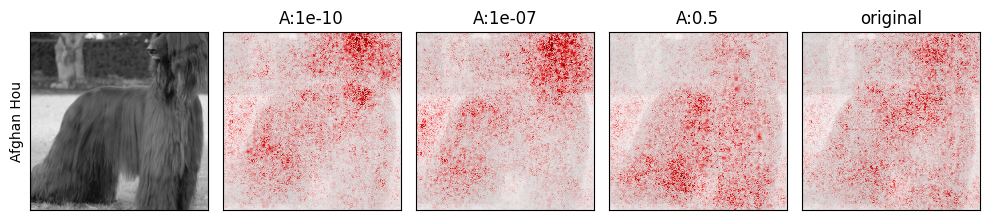

In [12]:

layer_ratio=0.5
remove_n = len(wrapper.all_convolutions) -  int(layer_ratio * len(wrapper.all_convolutions))
selected_convolutions = wrapper.all_convolutions[remove_n:]
wrapper.set_hook_modules(selected_convolutions)

flags = OmegaConf.create({
    'method': method,
    'alpha' :None,
    'p_value_threshold' : 0.05, 
    'variance_conservation' : True, 
    'exact_variance' :False,
    'gamma_infinity': True
})


input_attrib ='grad'

index=8014
alphas = [1e-10, 1e-7, 0.5]
fig, axes = plt.subplots(1, len(quantiles)+2, figsize=(10, 4))
axes = axes.flat
input_attrib = get_input_attrib(input_attrib)
alpha_plot(wrapper, input_attrib, valid_dataset, valid_dataset_2, labels, index, axes, alphas, device, flags)
plt.tight_layout()

In [6]:
for m in selected_convolutions:
    print(m.kernel_size)

(3, 3)
(3, 3)
(1, 1)
(3, 3)
(3, 3)
(3, 3)
(3, 3)
(1, 1)
(3, 3)
(3, 3)
